In [1]:
# setup and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


In [2]:
# load dataset with fallback options
dataset_loaded = False

# try sklearn first
if not dataset_loaded:
    try:
        from sklearn.datasets import load_boston
        data_obj = load_boston()
        features = data_obj.data
        prices = data_obj.target
        col_names = data_obj.feature_names
        dataset_loaded = True
        print('Got data from sklearn')
    except:
        pass

# try openml if sklearn failed
if not dataset_loaded:
    try:
        from sklearn.datasets import fetch_openml
        data_obj = fetch_openml(name='boston', version=1, as_frame=False)
        features = data_obj.data
        prices = data_obj.target
        col_names = data_obj.feature_names if hasattr(data_obj, 'feature_names') else [f'feat_{i}' for i in range(features.shape[1])]
        dataset_loaded = True
        print('Got data from openml')
    except:
        pass

# try csv url as last resort
if not dataset_loaded:
    try:
        url = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'
        data_frame = pd.read_csv(url)
        features = data_frame.drop('medv', axis=1).values
        prices = data_frame['medv'].values
        col_names = data_frame.drop('medv', axis=1).columns.tolist()
        dataset_loaded = True
        print('Got data from csv url')
    except:
        print('Could not load dataset')

print(f'Features shape: {features.shape}')
print(f'Prices shape: {prices.shape}')
print(f'Number of columns: {len(col_names)}')
print(f'Column names: {col_names}')
print(f'Price range: {prices.min():.2f} to {prices.max():.2f}')
print(f'Average price: {prices.mean():.2f}, standard deviation: {prices.std():.2f}')


Got data from sklearn
Features shape: (506, 13)
Prices shape: (506,)
Number of columns: 13
Column names: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
Price range: 5.00 to 50.00
Average price: 22.53, standard deviation: 9.19


In [5]:
# split the data
feat_train, feat_test, price_train, price_test = train_test_split(
    features, prices, test_size=0.2, random_state=42
)

# normalize features
normalizer = StandardScaler()
feat_train_norm = normalizer.fit_transform(feat_train)
feat_test_norm = normalizer.transform(feat_test)

print(f'Training samples: {feat_train.shape[0]}')
print(f'Testing samples: {feat_test.shape[0]}')
print(f'Feature count: {feat_train.shape[1]}')


Training samples: 404
Testing samples: 102
Feature count: 13


In [6]:
# import regression models
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    HuberRegressor, SGDRegressor, PassiveAggressiveRegressor,
    GammaRegressor, PoissonRegressor, TweedieRegressor
)
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# build model dictionary
model_dict = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1, max_iter=2000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=2000),
    'SVR_RBF': SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1),
    'HuberRegressor': HuberRegressor(epsilon=1.35, max_iter=200),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'GammaRegressor': GammaRegressor(max_iter=200),
    'PoissonRegressor': PoissonRegressor(max_iter=200),
    'TweedieRegressor': TweedieRegressor(power=1.5, max_iter=200),
    'PassiveAggressiveRegressor': PassiveAggressiveRegressor(max_iter=1000, random_state=42),
    'SGDRegressor': SGDRegressor(max_iter=1000, random_state=42),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# add ridge variants
ridge_alphas = [0.01, 0.1, 10.0, 100.0]
for a in ridge_alphas:
    model_dict[f'Ridge_alpha_{a}'] = Ridge(alpha=a)

# add lasso variants
lasso_alphas = [0.01, 0.1, 1.0, 10.0]
for a in lasso_alphas:
    model_dict[f'Lasso_alpha_{a}'] = Lasso(alpha=a, max_iter=2000)

print(f'Total models to test: {len(model_dict)}')
print(f'Model list: {list(model_dict.keys())}')


Total models to test: 24
Model list: ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SVR_RBF', 'HuberRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor', 'GammaRegressor', 'PoissonRegressor', 'TweedieRegressor', 'PassiveAggressiveRegressor', 'SGDRegressor', 'DecisionTreeRegressor', 'KNeighborsRegressor', 'MLPRegressor', 'Ridge_alpha_0.01', 'Ridge_alpha_0.1', 'Ridge_alpha_10.0', 'Ridge_alpha_100.0', 'Lasso_alpha_0.01', 'Lasso_alpha_0.1', 'Lasso_alpha_1.0', 'Lasso_alpha_10.0']


In [7]:
# function to calculate all metrics
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {'r2': r2, 'rmse': rmse, 'mae': mae}

# function to train and evaluate a model
def train_and_evaluate(model_name, model, use_scaling=True):
    if use_scaling:
        X_tr = feat_train_norm
        X_te = feat_test_norm
    else:
        X_tr = feat_train
        X_te = feat_test

    # fit model
    model.fit(X_tr, price_train)

    # predictions
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_te)

    # metrics
    metrics_train = compute_metrics(price_train, pred_train)
    metrics_test = compute_metrics(price_test, pred_test)

    return {
        'model': model,
        'train_r2': metrics_train['r2'],
        'test_r2': metrics_test['r2'],
        'train_rmse': metrics_train['rmse'],
        'test_rmse': metrics_test['rmse'],
        'train_mae': metrics_train['mae'],
        'test_mae': metrics_test['mae'],
        'predictions': pred_test
    }

# train all models
all_results = {}

for m_name, m in model_dict.items():
    print(f'\nWorking on {m_name}...')

    try:
        # tree models don't need scaling
        needs_scaling = m_name not in ['RandomForestRegressor', 'GradientBoostingRegressor', 'DecisionTreeRegressor']

        result = train_and_evaluate(m_name, m, use_scaling=needs_scaling)
        all_results[m_name] = result

        print(f'  Train R2: {result["train_r2"]:.4f}, Test R2: {result["test_r2"]:.4f}')
        print(f'  Train RMSE: {result["train_rmse"]:.4f}, Test RMSE: {result["test_rmse"]:.4f}')
        print(f'  Train MAE: {result["train_mae"]:.4f}, Test MAE: {result["test_mae"]:.4f}')

    except Exception as err:
        print(f'  Error: {str(err)}')
        all_results[m_name] = {'error': str(err)}

successful = len([r for r in all_results.values() if 'error' not in r])
print(f'\nFinished training {successful} models successfully')



Working on LinearRegression...
  Train R2: 0.7509, Test R2: 0.6688
  Train RMSE: 4.6520, Test RMSE: 4.9286
  Train MAE: 3.3148, Test MAE: 3.1891

Working on Ridge...
  Train R2: 0.7509, Test R2: 0.6685
  Train RMSE: 4.6522, Test RMSE: 4.9308
  Train MAE: 3.3087, Test MAE: 3.1857

Working on Lasso...
  Train R2: 0.7450, Test R2: 0.6501
  Train RMSE: 4.7063, Test RMSE: 5.0652
  Train MAE: 3.2658, Test MAE: 3.2418

Working on ElasticNet...
  Train R2: 0.7447, Test R2: 0.6563
  Train RMSE: 4.7097, Test RMSE: 5.0203
  Train MAE: 3.2562, Test MAE: 3.1921

Working on SVR_RBF...
  Train R2: 0.9699, Test R2: 0.8379
  Train RMSE: 1.6167, Test RMSE: 3.4478
  Train MAE: 0.8501, Test MAE: 2.0675

Working on HuberRegressor...
  Train R2: 0.7263, Test R2: 0.6147
  Train RMSE: 4.8759, Test RMSE: 5.3155
  Train MAE: 3.1214, Test MAE: 3.1082

Working on RandomForestRegressor...
  Train R2: 0.9772, Test R2: 0.8923
  Train RMSE: 1.4066, Test RMSE: 2.8110
  Train MAE: 0.9035, Test MAE: 2.0395

Working on 

In [8]:
# setup cross-validation
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

cv_data = {}

for m_name, m in model_dict.items():
    if m_name in all_results and 'error' not in all_results[m_name]:
        print(f'Cross-validating {m_name}...')

        try:
            # prepare data for cv
            if m_name in ['RandomForestRegressor', 'GradientBoostingRegressor', 'DecisionTreeRegressor']:
                X_cv = features
                y_cv = prices
            else:
                X_cv = normalizer.fit_transform(features)
                y_cv = prices

            # get cv scores
            r2_scores = cross_val_score(m, X_cv, y_cv, cv=cv_folds, scoring='r2')
            rmse_scores = -cross_val_score(m, X_cv, y_cv, cv=cv_folds, scoring='neg_root_mean_squared_error')
            mae_scores = -cross_val_score(m, X_cv, y_cv, cv=cv_folds, scoring='neg_mean_absolute_error')

            cv_data[m_name] = {
                'cv_r2_mean': r2_scores.mean(),
                'cv_r2_std': r2_scores.std(),
                'cv_rmse_mean': rmse_scores.mean(),
                'cv_rmse_std': rmse_scores.std(),
                'cv_mae_mean': mae_scores.mean(),
                'cv_mae_std': mae_scores.std()
            }

            print(f'  CV R2: {r2_scores.mean():.4f} (+/- {r2_scores.std()*2:.4f})')
            print(f'  CV RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std()*2:.4f})')
            print(f'  CV MAE: {mae_scores.mean():.4f} (+/- {mae_scores.std()*2:.4f})')

        except Exception as err:
            print(f'  CV failed: {str(err)}')
            cv_data[m_name] = {'error': str(err)}

# merge cv results
for m_name in all_results.keys():
    if m_name in cv_data and 'error' not in cv_data[m_name]:
        all_results[m_name].update(cv_data[m_name])


Cross-validating LinearRegression...
  CV R2: 0.7152 (+/- 0.0749)
  CV RMSE: 4.8428 (+/- 0.3794)
  CV MAE: 3.3885 (+/- 0.3746)
Cross-validating Ridge...
  CV R2: 0.7152 (+/- 0.0750)
  CV RMSE: 4.8427 (+/- 0.3819)
  CV MAE: 3.3833 (+/- 0.3773)
Cross-validating Lasso...
  CV R2: 0.7088 (+/- 0.0818)
  CV RMSE: 4.8959 (+/- 0.4490)
  CV MAE: 3.3686 (+/- 0.4203)
Cross-validating ElasticNet...
  CV R2: 0.7092 (+/- 0.0766)
  CV RMSE: 4.8948 (+/- 0.4340)
  CV MAE: 3.3492 (+/- 0.4614)
Cross-validating SVR_RBF...
  CV R2: 0.8763 (+/- 0.0588)
  CV RMSE: 3.1853 (+/- 0.7930)
  CV MAE: 2.1384 (+/- 0.4600)
Cross-validating HuberRegressor...
  CV R2: 0.6901 (+/- 0.1083)
  CV RMSE: 5.0465 (+/- 0.7674)
  CV MAE: 3.2357 (+/- 0.5123)
Cross-validating RandomForestRegressor...
  CV R2: 0.8714 (+/- 0.0664)
  CV RMSE: 3.2430 (+/- 0.9106)
  CV MAE: 2.1945 (+/- 0.4099)
Cross-validating GradientBoostingRegressor...
  CV R2: 0.8950 (+/- 0.0564)
  CV RMSE: 2.9269 (+/- 0.8318)
  CV MAE: 2.0924 (+/- 0.2900)
Cross-val

In [9]:
# build results table
table_rows = []

for m_name in sorted(all_results.keys()):
    if 'error' not in all_results[m_name]:
        row_dict = {'Model': m_name}
        row_dict['Test R2'] = all_results[m_name].get('test_r2', np.nan)
        row_dict['Test RMSE'] = all_results[m_name].get('test_rmse', np.nan)
        row_dict['Test MAE'] = all_results[m_name].get('test_mae', np.nan)

        if 'cv_r2_mean' in all_results[m_name]:
            row_dict['CV R2 Mean'] = all_results[m_name]['cv_r2_mean']
            row_dict['CV R2 Std'] = all_results[m_name]['cv_r2_std']
            row_dict['CV RMSE Mean'] = all_results[m_name]['cv_rmse_mean']
            row_dict['CV RMSE Std'] = all_results[m_name]['cv_rmse_std']
            row_dict['CV MAE Mean'] = all_results[m_name]['cv_mae_mean']
            row_dict['CV MAE Std'] = all_results[m_name]['cv_mae_std']

        table_rows.append(row_dict)

results_df = pd.DataFrame(table_rows)
print('\n=== All Results ===\n')
print(results_df.to_string(index=False))

# show top performers
print('\n=== Top 10 by Test R2 ===\n')
top_models_df = results_df.sort_values('Test R2', ascending=False).head(10)
print(top_models_df.to_string(index=False))



=== All Results ===

                     Model   Test R2  Test RMSE  Test MAE  CV R2 Mean  CV R2 Std  CV RMSE Mean  CV RMSE Std  CV MAE Mean  CV MAE Std
     DecisionTreeRegressor  0.857963   3.227395  2.394118    0.761935   0.071972      4.419269     0.810799     3.054269    0.463770
                ElasticNet  0.656317   5.020314  3.192091    0.709206   0.038319      4.894765     0.217021     3.349207    0.230703
            GammaRegressor  0.643184   5.115337  3.165119    0.628591   0.034343      5.547966     0.310389     3.644020    0.351643
 GradientBoostingRegressor  0.915334   2.491759  1.912243    0.894967   0.028225      2.926857     0.415918     2.092412    0.144993
            HuberRegressor  0.614712   5.315506  3.108168    0.690051   0.054131      5.046482     0.383715     3.235678    0.256146
       KNeighborsRegressor  0.719017   4.539331  2.592157    0.746763   0.044817      4.552408     0.267086     2.891156    0.204318
                     Lasso  0.650138   5.065248

In [10]:
# get model names and scores
valid_models = [m for m in sorted(all_results.keys()) if 'error' not in all_results[m]]
r2_values = [all_results[m]['test_r2'] for m in valid_models]
rmse_values = [all_results[m]['test_rmse'] for m in valid_models]
mae_values = [all_results[m]['test_mae'] for m in valid_models]

# create comparison plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# R2 plot
axs[0].barh(range(len(valid_models)), r2_values, color='steelblue')
axs[0].set_yticks(range(len(valid_models)))
axs[0].set_yticklabels(valid_models, fontsize=8)
axs[0].set_xlabel('R2 Score', fontsize=10)
axs[0].set_title('Test R2 Comparison', fontsize=12)
axs[0].grid(True, alpha=0.3, axis='x')

# RMSE plot
axs[1].barh(range(len(valid_models)), rmse_values, color='coral')
axs[1].set_yticks(range(len(valid_models)))
axs[1].set_yticklabels(valid_models, fontsize=8)
axs[1].set_xlabel('RMSE', fontsize=10)
axs[1].set_title('Test RMSE Comparison', fontsize=12)
axs[1].grid(True, alpha=0.3, axis='x')

# MAE plot
axs[2].barh(range(len(valid_models)), mae_values, color='lightgreen')
axs[2].set_yticks(range(len(valid_models)))
axs[2].set_yticklabels(valid_models, fontsize=8)
axs[2].set_xlabel('MAE', fontsize=10)
axs[2].set_title('Test MAE Comparison', fontsize=12)
axs[2].grid(True, alpha=0.3, axis='x')

plt.suptitle('Model Performance Metrics', fontsize=14)
plt.tight_layout()
plt.show()


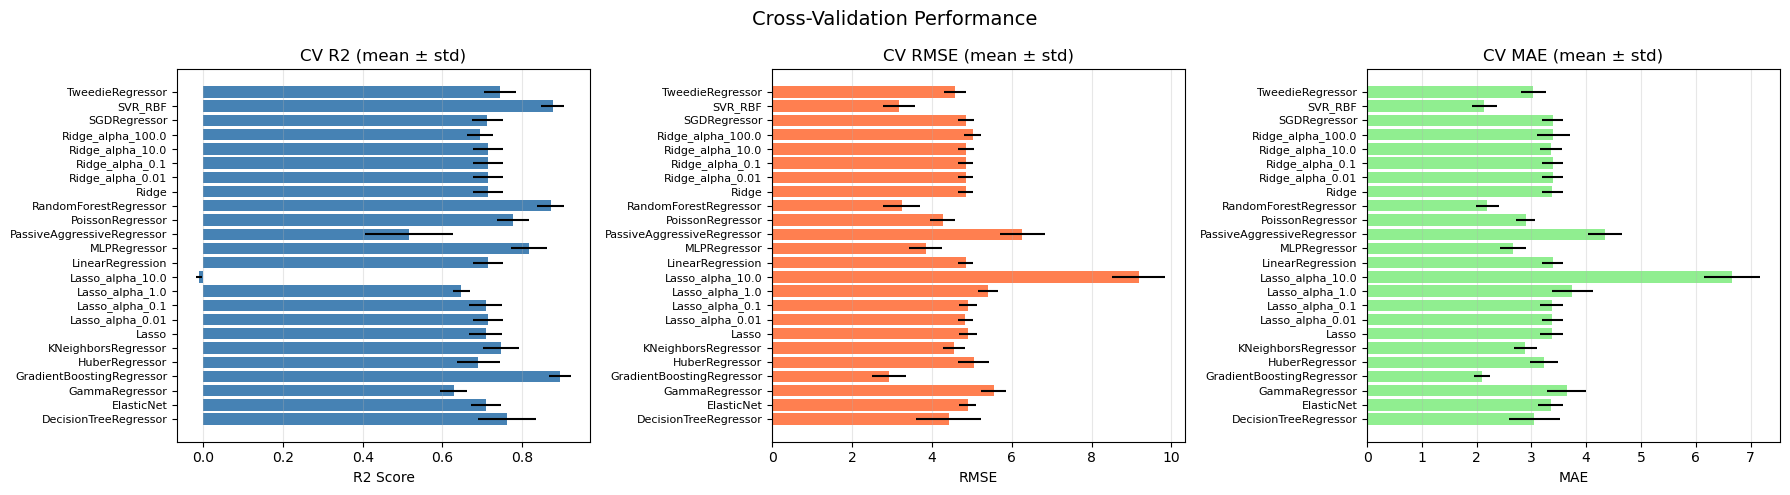

In [11]:
# models with cv results
cv_models = [m for m in sorted(all_results.keys())
             if 'error' not in all_results[m] and 'cv_r2_mean' in all_results[m]]

if cv_models:
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # CV R2
    cv_r2_means = [all_results[m]['cv_r2_mean'] for m in cv_models]
    cv_r2_stds = [all_results[m]['cv_r2_std'] for m in cv_models]

    axs[0].barh(range(len(cv_models)), cv_r2_means, xerr=cv_r2_stds, color='steelblue')
    axs[0].set_yticks(range(len(cv_models)))
    axs[0].set_yticklabels(cv_models, fontsize=8)
    axs[0].set_xlabel('R2 Score', fontsize=10)
    axs[0].set_title('CV R2 (mean ± std)', fontsize=12)
    axs[0].grid(True, alpha=0.3, axis='x')

    # CV RMSE
    cv_rmse_means = [all_results[m]['cv_rmse_mean'] for m in cv_models]
    cv_rmse_stds = [all_results[m]['cv_rmse_std'] for m in cv_models]

    axs[1].barh(range(len(cv_models)), cv_rmse_means, xerr=cv_rmse_stds, color='coral')
    axs[1].set_yticks(range(len(cv_models)))
    axs[1].set_yticklabels(cv_models, fontsize=8)
    axs[1].set_xlabel('RMSE', fontsize=10)
    axs[1].set_title('CV RMSE (mean ± std)', fontsize=12)
    axs[1].grid(True, alpha=0.3, axis='x')

    # CV MAE
    cv_mae_means = [all_results[m]['cv_mae_mean'] for m in cv_models]
    cv_mae_stds = [all_results[m]['cv_mae_std'] for m in cv_models]

    axs[2].barh(range(len(cv_models)), cv_mae_means, xerr=cv_mae_stds, color='lightgreen')
    axs[2].set_yticks(range(len(cv_models)))
    axs[2].set_yticklabels(cv_models, fontsize=8)
    axs[2].set_xlabel('MAE', fontsize=10)
    axs[2].set_title('CV MAE (mean ± std)', fontsize=12)
    axs[2].grid(True, alpha=0.3, axis='x')

    plt.suptitle('Cross-Validation Performance', fontsize=14)
    plt.tight_layout()
    plt.show()


In [12]:
# find top 6 models
top_6 = sorted([(m, all_results[m]['test_r2']) for m in all_results.keys()
                if 'error' not in all_results[m]],
               key=lambda x: x[1], reverse=True)[:6]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (m_name, r2_val) in enumerate(top_6):
    preds = all_results[m_name]['predictions']

    axs[i].scatter(price_test, preds, alpha=0.6, s=30)
    min_val = min(price_test.min(), preds.min())
    max_val = max(price_test.max(), preds.max())
    axs[i].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
    axs[i].set_xlabel('Actual Price', fontsize=10)
    axs[i].set_ylabel('Predicted Price', fontsize=10)
    axs[i].set_title(f'{m_name}\nR2: {r2_val:.4f}', fontsize=10)
    axs[i].grid(True, alpha=0.3)
    axs[i].legend()

plt.suptitle('Top 6 Models: Predicted vs Actual', fontsize=14)
plt.tight_layout()
plt.show()


In [13]:
# extract ridge and lasso results
ridge_list = [(m, all_results[m]) for m in all_results.keys()
              if m.startswith('Ridge') and 'error' not in all_results[m]]
lasso_list = [(m, all_results[m]) for m in all_results.keys()
              if m.startswith('Lasso') and 'error' not in all_results[m]]

if ridge_list or lasso_list:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    if ridge_list:
        ridge_names = [m for m, _ in ridge_list]
        ridge_r2 = [r['test_r2'] for _, r in ridge_list]
        ridge_rmse = [r['test_rmse'] for _, r in ridge_list]

        # get alpha values
        alpha_vals = []
        for m in ridge_names:
            if 'alpha_' in m:
                try:
                    alpha_vals.append(float(m.split('alpha_')[1]))
                except:
                    alpha_vals.append(1.0)
            else:
                alpha_vals.append(1.0)

        axs[0].semilogx(alpha_vals, ridge_r2, 'o-', linewidth=2, markersize=8, label='R2', color='blue')
        axs[0].set_xlabel('Alpha (log scale)', fontsize=10)
        axs[0].set_ylabel('Test R2', fontsize=10, color='blue')
        axs[0].set_title('Ridge: Alpha vs R2', fontsize=12)
        axs[0].grid(True, alpha=0.3)
        axs[0].tick_params(axis='y', labelcolor='blue')

        ax2 = axs[0].twinx()
        ax2.semilogx(alpha_vals, ridge_rmse, 's-', color='red', linewidth=2, markersize=8, label='RMSE')
        ax2.set_ylabel('Test RMSE', fontsize=10, color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.legend(loc='upper right')

    if lasso_list:
        lasso_names = [m for m, _ in lasso_list]
        lasso_r2 = [r['test_r2'] for _, r in lasso_list]
        lasso_rmse = [r['test_rmse'] for _, r in lasso_list]

        # get alpha values
        alpha_vals = []
        for m in lasso_names:
            if 'alpha_' in m:
                try:
                    alpha_vals.append(float(m.split('alpha_')[1]))
                except:
                    alpha_vals.append(0.1)
            else:
                alpha_vals.append(0.1)

        axs[1].semilogx(alpha_vals, lasso_r2, 'o-', linewidth=2, markersize=8, label='R2', color='blue')
        axs[1].set_xlabel('Alpha (log scale)', fontsize=10)
        axs[1].set_ylabel('Test R2', fontsize=10, color='blue')
        axs[1].set_title('Lasso: Alpha vs R2', fontsize=12)
        axs[1].grid(True, alpha=0.3)
        axs[1].tick_params(axis='y', labelcolor='blue')

        ax2 = axs[1].twinx()
        ax2.semilogx(alpha_vals, lasso_rmse, 's-', color='red', linewidth=2, markersize=8, label='RMSE')
        ax2.set_ylabel('Test RMSE', fontsize=10, color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


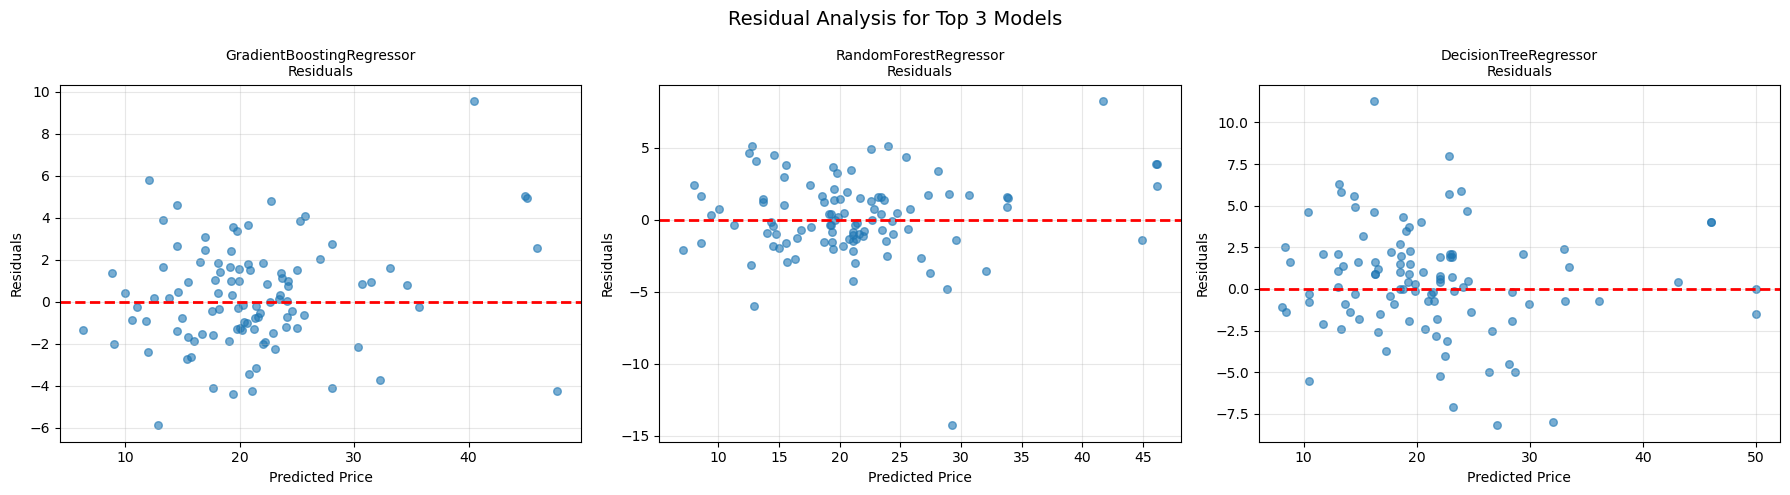

In [14]:
# top 3 models
top_3 = sorted([(m, all_results[m]['test_r2']) for m in all_results.keys()
               if 'error' not in all_results[m]],
              key=lambda x: x[1], reverse=True)[:3]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, (m_name, r2_val) in enumerate(top_3):
    preds = all_results[m_name]['predictions']
    residuals = price_test - preds

    axs[i].scatter(preds, residuals, alpha=0.6, s=30)
    axs[i].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axs[i].set_xlabel('Predicted Price', fontsize=10)
    axs[i].set_ylabel('Residuals', fontsize=10)
    axs[i].set_title(f'{m_name}\nResiduals', fontsize=10)
    axs[i].grid(True, alpha=0.3)

plt.suptitle('Residual Analysis for Top 3 Models', fontsize=14)
plt.tight_layout()
plt.show()


In [15]:
# tree models to check
tree_model_names = ['RandomForestRegressor', 'GradientBoostingRegressor', 'DecisionTreeRegressor']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, m_name in enumerate(tree_model_names):
    if m_name in all_results and 'error' not in all_results[m_name]:
        m = all_results[m_name]['model']
        if hasattr(m, 'feature_importances_'):
            importances = m.feature_importances_
            sorted_idx = np.argsort(importances)[::-1]

            axs[i].barh(range(len(col_names)), importances[sorted_idx], color='teal')
            axs[i].set_yticks(range(len(col_names)))
            axs[i].set_yticklabels([col_names[j] for j in sorted_idx], fontsize=8)
            axs[i].set_xlabel('Importance', fontsize=10)
            axs[i].set_title(f'{m_name}\nFeature Importance', fontsize=10)
            axs[i].grid(True, alpha=0.3, axis='x')

plt.suptitle('Feature Importance Analysis', fontsize=14)
plt.tight_layout()
plt.show()


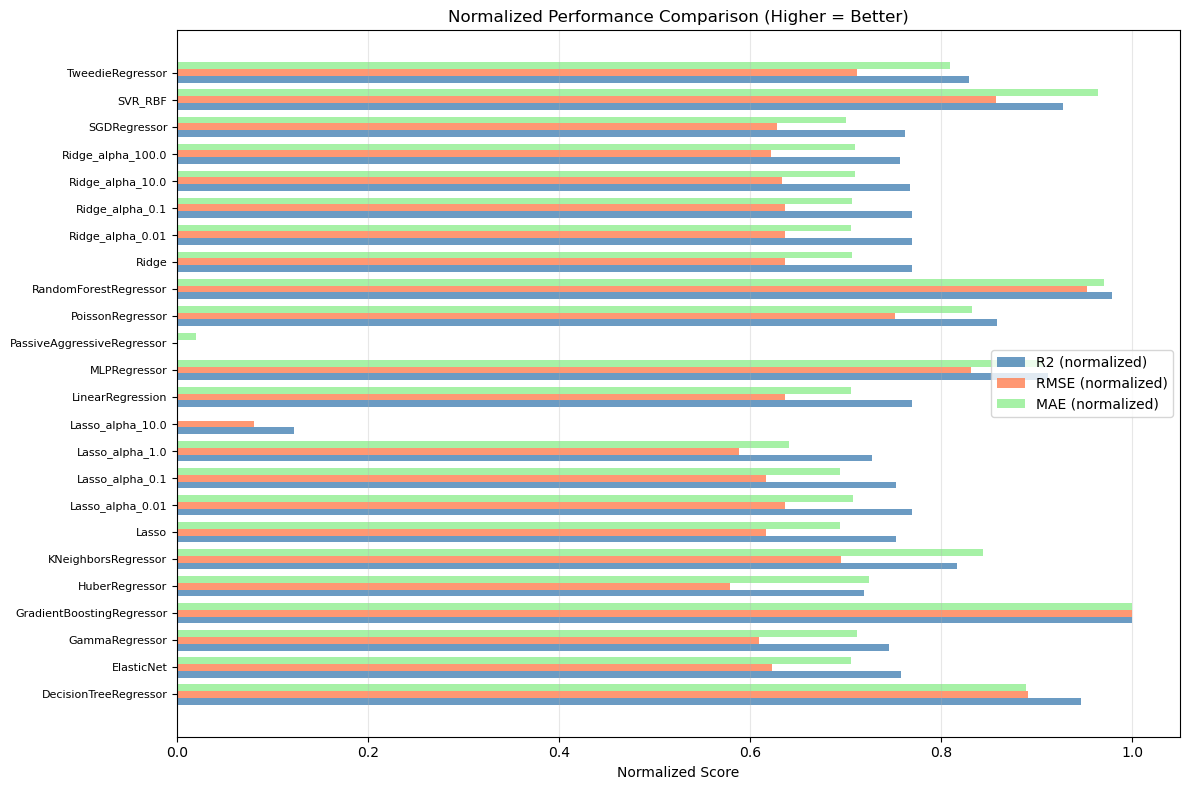


=== Top 5 Models by Combined Score ===

GradientBoostingRegressor:
  Test R2: 0.9153
  Test RMSE: 2.4918
  Test MAE: 1.9122
  CV R2: 0.8950 (+/- 0.0282)

RandomForestRegressor:
  Test R2: 0.8923
  Test RMSE: 2.8110
  Test MAE: 2.0395
  CV R2: 0.8714 (+/- 0.0332)

SVR_RBF:
  Test R2: 0.8379
  Test RMSE: 3.4478
  Test MAE: 2.0675
  CV R2: 0.8763 (+/- 0.0294)

DecisionTreeRegressor:
  Test R2: 0.8580
  Test RMSE: 3.2274
  Test MAE: 2.3941
  CV R2: 0.7619 (+/- 0.0720)

MLPRegressor:
  Test R2: 0.8205
  Test RMSE: 3.6280
  Test MAE: 2.3177
  CV R2: 0.8173 (+/- 0.0462)



In [16]:
# normalize scores for comparison
model_list = [m for m in sorted(all_results.keys()) if 'error' not in all_results[m]]
r2_vals = [all_results[m]['test_r2'] for m in model_list]
rmse_vals = [all_results[m]['test_rmse'] for m in model_list]
mae_vals = [all_results[m]['test_mae'] for m in model_list]

# normalize to 0-1
r2_norm = (np.array(r2_vals) - min(r2_vals)) / (max(r2_vals) - min(r2_vals) + 1e-10)
rmse_norm = 1 - (np.array(rmse_vals) - min(rmse_vals)) / (max(rmse_vals) - min(rmse_vals) + 1e-10)
mae_norm = 1 - (np.array(mae_vals) - min(mae_vals)) / (max(mae_vals) - min(mae_vals) + 1e-10)

# combined score
combined = (r2_norm + rmse_norm + mae_norm) / 3

# plot
fig, ax = plt.subplots(figsize=(12, 8))
x_pos = np.arange(len(model_list))
w = 0.25

ax.barh(x_pos - w, r2_norm, w, label='R2 (normalized)', alpha=0.8, color='steelblue')
ax.barh(x_pos, rmse_norm, w, label='RMSE (normalized)', alpha=0.8, color='coral')
ax.barh(x_pos + w, mae_norm, w, label='MAE (normalized)', alpha=0.8, color='lightgreen')

ax.set_yticks(x_pos)
ax.set_yticklabels(model_list, fontsize=8)
ax.set_xlabel('Normalized Score', fontsize=10)
ax.set_title('Normalized Performance Comparison (Higher = Better)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# print best models
print('\n=== Top 5 Models by Combined Score ===\n')
top_5_idx = np.argsort(combined)[::-1][:5]
for idx in top_5_idx:
    m = model_list[idx]
    print(f'{m}:')
    print(f'  Test R2: {r2_vals[idx]:.4f}')
    print(f'  Test RMSE: {rmse_vals[idx]:.4f}')
    print(f'  Test MAE: {mae_vals[idx]:.4f}')
    if 'cv_r2_mean' in all_results[m]:
        print(f'  CV R2: {all_results[m]["cv_r2_mean"]:.4f} (+/- {all_results[m]["cv_r2_std"]:.4f})')
    print()
